In [37]:
# import torch functions
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

# import torchvision functions
import torchvision
from torchvision.models import vgg16
import torchvision.utils as vutils
from torchvision import datasets, transforms, utils
import torchvision.transforms as T

# import other functions
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from itertools import islice
from PIL import Image
import time 
import torchsummary
from sklearn.metrics import accuracy_score


In [3]:
original_dataset_dir = r'C:\Users\pauli\Documents\M2\ML et DL\projet\Git\DamageDetection'

In [4]:
train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

In [5]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [6]:
# fonction pour entrainer les modeles

def fit(model, train_loader, val_loader, epochs, steps_per_epoch, validation_steps):
    epoch_nums = []
    training_acc = []
    validation_acc = []
    training_loss = []
    validation_loss = []
    
    for epoch in range(epochs):
        accuracy = 0.0
        running_loss = 0.0
        start_time = time.time()
        # Entraîne le modèle sur les données d'entraînement
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # Entraîne le modèle sur un lot de données
            outputs = model(images)
            loss = criterion(outputs, labels.float().view(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #running_loss += loss.item()
            accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
            running_loss += loss.item()
        
            if (i+1) % steps_per_epoch == 0:
                break
        train_loss = running_loss / steps_per_epoch
        train_acc = accuracy / steps_per_epoch 
                
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for i, (images, labels) in enumerate(val_loader):
                outputs = model(images)
                val_loss += criterion(outputs, labels.float().view(-1,1)).item()
                _, predicted = torch.max(outputs.data, 1)
                val_acc += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
                
                if i >= validation_steps:
                    break
        
        val_loss /= validation_steps
        val_acc /= validation_steps 

        epoch_nums.append(epoch+1)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_acc.append(train_acc)
        validation_acc.append(val_acc)
        
        elapsed_time = time.time() - start_time
        print(elapsed_time)
        print(f"Epoch [{epoch+1}/{epochs}], Time : {elapsed_time:.4f}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
    return {
        'training_acc': training_acc,
        'validation_acc': validation_acc,
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }

def fit_transfer(model, train_features, train_labels, val_features, val_labels, epochs, steps_per_epoch, validation_steps):
    epoch_nums = []
    training_acc = []
    validation_acc = []
    training_loss = []
    validation_loss = []
    
    for epoch in range(epochs):
        accuracy = 0.0
        running_loss = 0.0
        start_time = time.time()
        # Entraîne le modèle sur les données d'entraînement
        model.train()
        
        # Entraîne le modèle sur un lot de données
        outputs = model(train_features)
        loss = criterion(outputs, train_labels.float().view(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #running_loss += loss.item()
        accuracy += (torch.round(outputs) == train_labels.float().view(-1,1)).sum().item() / len(train_labels)
        running_loss += loss.item()
            
        train_loss = running_loss 
        train_acc = accuracy
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            outputs = model(val_features)
            val_loss += criterion(outputs, val_labels.float().view(-1,1)).item()
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (torch.round(outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)

        epoch_nums.append(epoch+1)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_acc.append(train_acc)
        validation_acc.append(val_acc)
        
        elapsed_time = time.time() - start_time
        print(elapsed_time)
        print(f"Epoch [{epoch+1}/{epochs}], Time : {elapsed_time:.4f}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
    return {
        'training_acc': training_acc,
        'validation_acc': validation_acc,
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }


# Extraire les caractéristiques des images
def extract_features(data_loader, sample_count, conv_base, batch_size, last_size):
    features = torch.zeros(sample_count, 512, last_size, last_size)
    labels = torch.zeros(sample_count, dtype=torch.long)
    
    i = 0
    for inputs_batch, labels_batch in data_loader:
        with torch.no_grad():
            features_batch = conv_base(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


# Transcription du modele vgg16 en pytorch

Ici nous ne faisons que la traduction du code keras effectué par Cao

## Récupération des features de vgg16

In [33]:
# Chargment du modèle pré-entraîné ResNet18
modelvgg16 = torchvision.models.vgg16(pretrained=True)
torchsummary.summary(modelvgg16, (3,150,150))

# Extraction des caractéristiques
modelvgg16 = modelvgg16.features[:31] # nombre de caractéristiques en entrée de la couche fc
torchsummary.summary(modelvgg16, (3,150,150))

C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [34]:
datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size=20

train_dataset = ImageFolder(original_dataset_dir+'/train_another', transform=datagen)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

val_dataset = ImageFolder(original_dataset_dir+'/validation_another', transform=datagen)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

test_dataset = ImageFolder(original_dataset_dir+'/test_another', transform=datagen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=True)


In [35]:
train_features, train_labels = extract_features(train_loader, 10000, modelvgg16, batch_size=batch_size,last_size=4)
validation_features, validation_labels = extract_features(val_loader, 2000, modelvgg16, batch_size=batch_size,last_size=4)
test_features, test_labels = extract_features(test_loader, 2000, modelvgg16, batch_size=batch_size,last_size=4)

# Reformater les caractéristiques pour être de forme (sample_count, 8192)
train_features = train_features.view(10000, 4 * 4 * 512)
validation_features = validation_features.view(2000, 4 * 4 * 512)
test_features = test_features.view(2000, 4 * 4 * 512)

## VGG16 sur un CNN simple

In [62]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(4 * 4 * 512, 256) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x
BinaryClassifier = BinaryClassifier()

criterion = nn.BCELoss()
optimizer = optim.RMSprop(BinaryClassifier.parameters(), lr=0.0001)


In [63]:
# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 100
validation_steps = 50

history = fit_transfer(BinaryClassifier, train_features, train_labels, validation_features, validation_labels, epochs, steps_per_epoch, validation_steps)


0.30835533142089844
Epoch [1/100], Time : 0.3084, Train Loss: 0.6920, Train Accuracy: 0.5131, Validation Loss: 0.7058, Validation Accuracy: 0.6165
0.30707526206970215
Epoch [2/100], Time : 0.3071, Train Loss: 0.6959, Train Accuracy: 0.6283, Validation Loss: 0.7119, Validation Accuracy: 0.5445
0.30626463890075684
Epoch [3/100], Time : 0.3063, Train Loss: 0.7155, Train Accuracy: 0.5554, Validation Loss: 0.5148, Validation Accuracy: 0.8010
0.32716894149780273
Epoch [4/100], Time : 0.3272, Train Loss: 0.5093, Train Accuracy: 0.8074, Validation Loss: 0.4446, Validation Accuracy: 0.8310
0.27551770210266113
Epoch [5/100], Time : 0.2755, Train Loss: 0.4373, Train Accuracy: 0.8378, Validation Loss: 0.3990, Validation Accuracy: 0.8455
0.35808682441711426
Epoch [6/100], Time : 0.3581, Train Loss: 0.3904, Train Accuracy: 0.8496, Validation Loss: 0.3740, Validation Accuracy: 0.8510
0.33693504333496094
Epoch [7/100], Time : 0.3369, Train Loss: 0.3611, Train Accuracy: 0.8582, Validation Loss: 0.3558,

0.31356096267700195
Epoch [57/100], Time : 0.3136, Train Loss: 0.1584, Train Accuracy: 0.9483, Validation Loss: 0.2188, Validation Accuracy: 0.9180
0.3181185722351074
Epoch [58/100], Time : 0.3181, Train Loss: 0.1580, Train Accuracy: 0.9476, Validation Loss: 0.2201, Validation Accuracy: 0.9170
0.3165934085845947
Epoch [59/100], Time : 0.3166, Train Loss: 0.1565, Train Accuracy: 0.9480, Validation Loss: 0.2188, Validation Accuracy: 0.9185
0.28575730323791504
Epoch [60/100], Time : 0.2858, Train Loss: 0.1562, Train Accuracy: 0.9467, Validation Loss: 0.2200, Validation Accuracy: 0.9155
0.26470208168029785
Epoch [61/100], Time : 0.2647, Train Loss: 0.1554, Train Accuracy: 0.9484, Validation Loss: 0.2186, Validation Accuracy: 0.9160
0.29555845260620117
Epoch [62/100], Time : 0.2956, Train Loss: 0.1545, Train Accuracy: 0.9473, Validation Loss: 0.2208, Validation Accuracy: 0.9160
0.3270590305328369
Epoch [63/100], Time : 0.3271, Train Loss: 0.1538, Train Accuracy: 0.9495, Validation Loss: 0.2

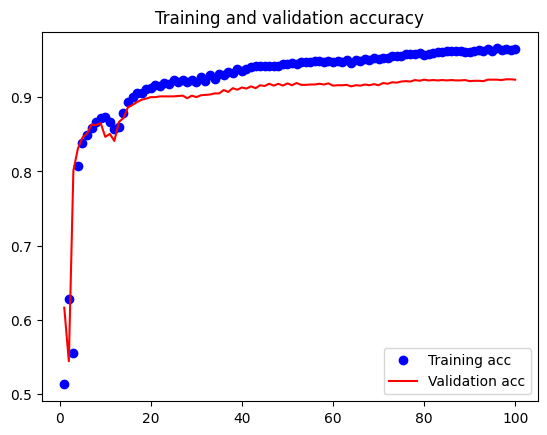

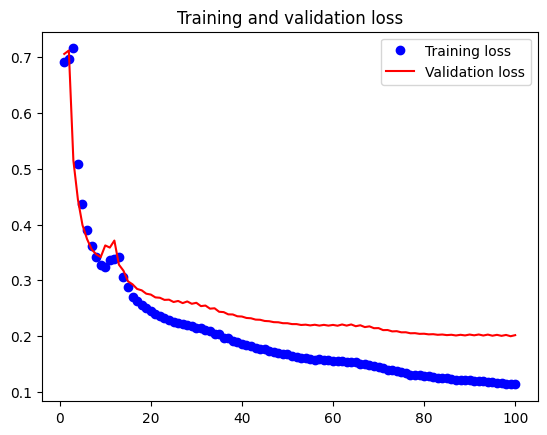

In [64]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## VGG16 sur Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(C = 1)
logisticRegr.fit(train_features,train_labels)
#balanced test set 
score1 = logisticRegr.score(validation_features, validation_labels)
print("Validation acc = ", score1)
score2 = logisticRegr.score(test_features, test_labels)
print("Test acc = ", score2)

Validation acc =  0.925
Validation acc =  0.9215


C:\Users\pattal\.conda\envs\DL\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np

kr = KernelRidge(alpha=1, kernel='rbf')
kr.fit(train_features,train_labels)

y_pred_val = kr.predict(validation_features)
y_pred_test = kr.predict(test_features)

y_pred_val = np.round(y_pred_val)
y_pred_test = np.round(y_pred_test)

val_acc = accuracy_score(validation_labels, y_pred_val)
test_acc = accuracy_score(test_labels, y_pred_test)

print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Validation accuracy:  0.9265
Test accuracy:  0.934


In [39]:
from sklearn.ensemble import GradientBoostingClassifier 
clf = GradientBoostingClassifier()
clf.fit(train_features,train_labels)

score1 = clf.score(validation_features, validation_labels)
print("Validation acc = ", score1)
score2 = clf.score(test_features, test_labels)
print("Test acc = ", score2)

Validation acc =  0.886
Test acc =  0.906


# Resnet

Ici nous apportons une autre approche de transfer learning en utilisant le modele Resnet plutot que VGG16

## Extraire les features de Resnet

In [7]:
modelresnet = torchvision.models.resnet18(pretrained=True)
torchsummary.summary(modelresnet, (3,150,150))
# Extraction des caractéristiques
class ResNet(nn.Module):
    def __init__(self, modelresnet):
        super().__init__()
        #garder les couches avant les denses
        self.model = nn.Sequential(*list(modelresnet.children())[:-2])
        
    def forward(self, x):
        return self.model(x)
    
model2 = ResNet(modelresnet)
torchsummary.summary(model2, (3,150,150))

C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

In [8]:
datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size=20

train_dataset = ImageFolder(original_dataset_dir+'/train_another', transform=datagen)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

val_dataset = ImageFolder(original_dataset_dir+'/validation_another', transform=datagen)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

test_dataset = ImageFolder(original_dataset_dir+'/test_another', transform=datagen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=True)


In [9]:
train_features, train_labels = extract_features(train_loader, 10000, model2, batch_size=batch_size,last_size=5)
validation_features, validation_labels = extract_features(val_loader, 2000, model2, batch_size=batch_size,last_size=5)
test_features, test_labels = extract_features(test_loader, 2000, model2, batch_size=batch_size,last_size=5)

# Reformater les caractéristiques pour être de forme (sample_count, 8192)
train_features = train_features.view(10000, 5 * 5 * 512)
validation_features = validation_features.view(2000, 5 * 5 * 512)
test_features = test_features.view(2000, 5 * 5 * 512)

## Resnet sur des modeles de machine learning

In [49]:
from sklearn.ensemble import GradientBoostingClassifier 
clf = GradientBoostingClassifier()
clf.fit(train_features,train_labels)

score1 = clf.score(validation_features, validation_labels)
print("Validation acc = ", score1)
score2 = clf.score(test_features, test_labels)
print("Test acc = ", score2)

Validation acc =  0.8895
Test acc =  0.6945


In [45]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=20, min_samples_split=200, min_samples_leaf=100)
tree.fit(train_features,train_labels)

y_pred_val = tree.predict(validation_features)
y_pred_test = tree.predict(test_features)

y_pred_val = np.round(y_pred_val)
y_pred_test = np.round(y_pred_test)

val_acc = accuracy_score(validation_labels, y_pred_val)
test_acc = accuracy_score(test_labels, y_pred_test)

print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Validation accuracy:  0.7585
Test accuracy:  0.588


In [54]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_features,train_labels)

y_pred_val = knn.predict(validation_features)
y_pred_test = knn.predict(test_features)

y_pred_val = np.round(y_pred_val)
y_pred_test = np.round(y_pred_test)

val_acc = accuracy_score(validation_labels, y_pred_val)
test_acc = accuracy_score(test_labels, y_pred_test)

print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Validation accuracy:  0.6275
Test accuracy:  0.9235


In [43]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np

kr = KernelRidge(alpha=1, kernel='rbf')
kr.fit(train_features,train_labels)

from sklearn.metrics import accuracy_score

y_pred_val = kr.predict(validation_features)
y_pred_test = kr.predict(test_features)

y_pred_val = np.round(y_pred_val)
y_pred_test = np.round(y_pred_test)

val_acc = accuracy_score(validation_labels, y_pred_val)
test_acc = accuracy_score(test_labels, y_pred_test)

print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Validation accuracy:  0.9085
Test accuracy:  0.711


In [48]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)

rf.fit(train_features,train_labels)


y_pred_val = rf.predict(validation_features)
y_pred_test = rf.predict(test_features)

y_pred_val = np.round(y_pred_val)
y_pred_test = np.round(y_pred_test)

val_acc = accuracy_score(validation_labels, y_pred_val)
test_acc = accuracy_score(test_labels, y_pred_test)

print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Validation accuracy:  0.869
Test accuracy:  0.631


In [52]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(C = 1)
logisticRegr.fit(train_features,train_labels)
#balanced test set 
score1 = logisticRegr.score(validation_features, validation_labels)
print("Validation acc = ", score1)
score2 = logisticRegr.score(test_features, test_labels)
print("Test acc = ", score2)

C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Validation acc =  0.919
Test acc =  0.7025


In [51]:
from sklearn.svm import SVC

# Instanciation du modèle SVC
svc_model = SVC(kernel='linear')
svc_model.fit(train_features,train_labels)

y_pred_val = svc_model.predict(validation_features)
y_pred_test = svc_model.predict(test_features)

y_pred_val = np.round(y_pred_val)
y_pred_test = np.round(y_pred_test)

val_acc = accuracy_score(validation_labels, y_pred_val)
test_acc = accuracy_score(test_labels, y_pred_test)

print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Validation accuracy:  0.9165
Test accuracy:  0.703
